# CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Summer 2018 ###

# Using Optimization for Smart Delivery #

# Group
* Lin Qi (lqi3@wisc.edu)
* Jianwei Ke (jke9@wisc.edu) 
* Yuhan Xie (xie75@wisc.edu) 
* Zidong Zhang (zzhang773@wisc.edu)
* Jingyao Wei (jwei44@wisc.edu)

# Table of Contents

1. [Introduction](#Introduction)
1. [Data Generation](#Data Generation)
1. [Three Models](#Three-Models)
    1. [Brute Force](#A.Brute-Force-Model) 
        1. [Mathematicial Model](#Mathematicial-Model)
        1. [Implementation](#Implementation)
        1. [Result and Discussion](#Result-and-Discussion)
    1. [Vehicel Routing](#B.Vehicle-Routing-Model)
        1. [Mathematicial Model](#Mathematicial-Model)
        1. [Implementation](#Implementation)
        1. [Result and Discussion](#Result-and-Discussion)
    1. [Traveling Salesman Problem](#C.Traveling-Salesman-Problem)
        1. [Mathematicial Model](#TSP-Mathematicl-Model)
        1. [Implementation](#TSP-Implementation-and-Solution)
        1. [Result and Discussion](#TSP-Result-and-Discussion)
1. [Conclusion](#Conclusion)

# Introduction
    
Our project will use the different mathematical models to implement the optimization for smart delivery.

As technology advances, the food industry constantly works on innovating to keep customers having the best qualities and convenience. Expected food quality, the restaurant industry more and more tends to focus on or how to make customer service more convenient dining. With the rise of delivery options and online platforms, ordering and getting food has become a mainstream form. In 2017, Rafi Cohen shows that a vast majority of millennials (over 70%) states a definite preference for having their food delivered, rather than having to pick it up or dine in. he predicted that over the next few years, this number is only expected to go up as the next generation comes along. How restaurant meals to the home are undergoing rapid change as new online platforms, but no matter what kind of delivery applications, we all need to design model to optimize the interests of the customer and restaurant so that maximization the profit is what our team consider.

In our project, we use mixed-integer programming (MIP) model to optimize the delivery schedule of restaurants and we also write an algorithm to brute force the solution. From the restaurant to each customer’s home, we will try to get a best route to achieve profit maximization, which means we will minimize total cost (fuel cost and dish cost) and maximize the revenue (tips) as far as possible. Real data would be our pursuit, but since the data is hard to acquire, so we randomly generate data including time of delivery, dishes required, coordinate of delivery destination and tips, etc.

There are three different examples with the general setting and implementations in our project to optimize the profit:

1. Brute force: This model is a sample model to minimie the total cost. As mentioned before, we write down an algorithm to enumerate all the possibilities, which cause us only having one truck and a small amount of customers to implement. However, we use this model as the sample and verify the accuracy.

2. Traveling salesman problem: We use this model to optimize and improve the brute force model as well, which allows larger number of customers to be implemented, and also to achieve the minimum cost that includes trip cost and satisfaction cost. In this model, we add the tradeoff model to minimize cost and satisfactory customer as our goal.

3. Vehicle routing: In order to be more close to reality, we use the vehicle routing model to implement how to route more than one truck to meet customer demand. In this model, each truck must visit every customer and the sum of the customer's demands on routes visiting customer must be smaller or equal than the capacity of trucks.

The rest of the project will present the three models by their mathematical models and implement them in Julia with JuMP and Gurobi. After that, we discuss some results by the generated routes and plots. At the end, we summarize the whole project and give a future direction.

# Models and Solutions

## Data Generation

### Data Form 

To simulate real life situations, we random generate maps with the fashion of blocks and streets. The map is a $n*m$ matrix, each element of which represents an intersection of two streets. To simplify the model, we assume every customers or the restaurant locates at an intersections of two street. The cost is incurred when the deliveryman go from one intersection to an adjacent one. Tips of each deliver and cost of going through each street are randomly generated and could be reproduce by using the same random seed. 

### Parameters

The parameters of generating the map is followed:

$$ \text{latitude and longtitude} => \text{integers, the length and width of the map}$$
$$ 0 \leq density \leq 1 => \text{real number, density of customers in the map}$$
$$ \text{time_length} => \text{integers, the length of the time period that all orders are in}$$
$$ \text{time_length} => \text{integers, the maximun tips can be earned in each order}$$

### Math Model

The math model of random generation is followed:

#### number of customers
$$\text{number of customers} = \lceil \text{number  of  intersection}s * density \rceil$$

#### time and tips of each delivery
$$0 \leq \text{required time of delivery} \leq \lceil \text{time_length}\rceil$$
$$0 \leq \text{tips of delivery} \leq \lceil \text{max_tip} \rceil$$

#### cost of each road
$$0 \leq \text{cost of the road} \leq \lceil \text{time_length}/\text{number of intersections}*(1-density)^2$$

### implementation and sample result

In [1]:
using Graphs, NamedArrays, Clp, Combinatorics, Gurobi

seed = srand(42453)

# Parameters
latitude = 5
longtitude = 5
density = 0.1
time_length = 200
max_tip = 10
# ------------

vertical = 1
horizontal = 2

c = zeros(latitude, longtitude)  # Mark all nodes as normal nodes
time = zeros(latitude, longtitude)
cost = 2*time_length*ones(latitude, longtitude, 2)


tips = zeros(latitude, longtitude)

R = (ceil(Int64, rand() * latitude), ceil(Int64, rand() * longtitude))
c[R[1], R[2]] = 2 #generating Restaurant
customer_number = 0

while customer_number < ceil(density * latitude * longtitude)
    xx = ceil(Int64, rand() * latitude)
    yy = ceil(Int64, rand() * longtitude)
    if c[xx, yy] == 0
        c[xx, yy] = 1
        time[xx, yy] = ceil(rand() * time_length);
        tips[xx, yy] = ceil(rand() * max_tip);
        customer_number = customer_number + 1
    end
end

customer_n = 0
paths = 1
dists = Array{Int64}((longtitude-1)*latitude + longtitude*(latitude-1))
#customer = Array{Tuple(Int64, Int64)}(latitude*longtitude*density)
restaurant = 1
customer = Array{Int64}(ceil(Int64,longtitude*latitude*density))
tip = Array{Int64}(ceil(Int64,longtitude*latitude*density))
deadline = Array{Int64}(ceil(Int64,longtitude*latitude*density))
g = simple_inclist(latitude*longtitude)

for i in 1:latitude
    for j in 1:longtitude
        if c[i, j] == 1
            customer_n = customer_n + 1
            customer[customer_n] = (i-1)*longtitude+j
            tip[customer_n] = tips[i, j]
            deadline[customer_n] = time[i, j]
        end
        if c[i, j] == 2
            restaurant = (i-1)*longtitude+j
        end
        #cost[i][j][vertical] --> the cost from (i, j) to (i+1, j)
        #cost[i][j][horizontal] --> the cost from (i, j) to (i, j+1)
        if i != latitude #generate the cost of each legal route
            cost[i, j, vertical] = ceil(Int64, rand() * time_length/(latitude*longtitude)*((1-density).^2))
            add_edge!(g, (i-1)*longtitude + j, i*longtitude + j)
            dists[paths] = cost[i, j, vertical]
            paths = paths + 1
        end
        if j != longtitude
            cost[i, j, horizontal] = ceil(Int64, rand() * time_length/(latitude*longtitude)*((1-density).^2))
            add_edge!(g, (i-1)*longtitude + j, (i-1)*longtitude + j + 1)
            dists[paths] = cost[i, j, horizontal]
            paths = paths + 1
        end
    end
end

@printf("cost graph of the map:")

for i in 1:latitude
    if i != 1
        for j in 1:longtitude
            @printf("%2.d      ", cost[i-1, j, vertical])
        end
    end
    @printf("\n\n")
    for j in 1:longtitude
        if c[i, j] == 1
            @printf(" C  ")
        end
        if c[i, j] == 2

            @printf(" R  ")
        end
        if c[i, j] == 0
            @printf(" o  ")
        end
        if j != longtitude
            @printf("%2.d  ", cost[i, j, horizontal]);
        end
    end
    @printf("\n\n")
end

cost graph of the map:

 o   3   o   1   o   2   o   6   o  

 2       6       5       5       3      

 o   7   o   6   o   3   C   5   o  

 3       2       2       4       5      

 o   5   o   4   C   4   o   5   o  

 1       2       4       4       1      

 o   4   o   5   o   5   R   4   o  

 5       4       4       3       3      

 C   1   o   2   o   6   o   3   o  



### Interpretation

This is a $5*5$ map. Each number represents the cost of the street between the intersections at the ends of the street. "R" represents the position of the restaurant, "C" represents the position of a customer, "o" represents an simple intersection with no customer or restaurant at it.




## Brute Force Model

In the Brute Force (BF) model, we enumerate all the possible traveling orders with the starting and ending node being the restaurant and intermedia nodes being the customers (note that each specific traveling order corresponds to a specific route) Then we evaluate the cost of each traveling order and pick the one with the lowest cost.

To calculate to cost for a route, we use Dijkstra's algorithm to calculate the shortest distance between every successive pair of nodes. The sum of the shortest distances of all successive pairs will be our overall distance cost. In addition, we generate a desired order of delivery schedule which is equivalent to the maximal customer satisfactory schedule. The second part of our cost is then the dissimilarity between the desired order and the traveling order of each route. We use L1 norm of measure the discrepancy between the desired order and the traveling order.

Once we have the lowest cost traveling order, the last step is to backtrack the traveling order to get the specific traveling route again using Dijkstra's algorithm.

### Mathematicl Model

### 1. Data known for modeling

* A randomly generated map(graph) where the nodes represent all the possible sites and the edge represent the distance between the node.
* A randomly selected node from all the nodes in the map representing the restaurant.
* A set of randomly selected nodes representing the customers.
* A randomly generated order used as the desired order of delivery based on customer's requirement.
   
### 2. Objective Function

* Overall cost that is minimized by a detailed route.

### 3. Pseudocode
Input:<br>
resturant = {R}<br>
customers = {$C_1$, ..., $C_n$}<br>
desired_order = {R, $C_1$, $C_3$, $C_2$,..., R}<br>

    (1)Possible_order = all_permutation({R, $C_1$, $C_2$,...})<br>
    (2)Foreach order in Possible_order
        for i = 1 : length(order)-1
            current_node = order[i]
            next_node = order[i+1]
            dist = Dijkstra(curent_node,next_node)
            order_diff = order_difference(order, desired_order)
            roder_costs[order] = dist + $\lambda$*|order_diff|
        end
    (3) index = argmin(order_costs)
        optimal_order = order_costs[index]
        optimal_route = backtrack(optimal_order)
Output:<br>
optimal_route


## Brute Force Implementation and Solution

We implement our Brute Force algorithm with/with order difference as the trade-off. We also implement functions that draw the map and the optimal_route on the map.

First, we will show the optimal route if we consider the distance as the only cost. Then we will show the optimal route consider both distance and order difference as cost. Because the Brute Force takes considerably longer time compared to the TSP model, we do not generate the Pareto curve in the Brute Force case. Instead, we plot the Pareto curve in our TSP model(next section) over a larger dataset.

In the next section, We will also use the TSP model to process the same data, and show that the model generate the same optimal result.

cost graph of the map:

 0   2   0   1   C1   2   0   3   0  

 2       5       5       2       4      

 0   1   0   2   0   3   C2   3   0  

 4       4       3       4       4      

 0   4   0   3   C3   3   0   3   0  

 1       3       4       4       3      

 C4   1   0   4   0   2   R   1   0  

 3       2       2       3       2      

 C5   2   0   2   0   1   0   4   0  



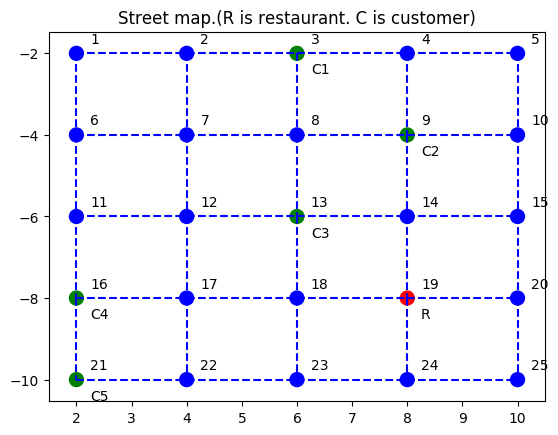

cost:
route 1: 40.0
route 2: 42.0
route 3: 52.0
route 4: 46.0
route 5: 54.0
route 6: 46.0
route 7: 48.0
route 8: 50.0
route 9: 60.0
route 10: 52.0
route 11: 62.0
route 12: 52.0
route 13: 57.0
route 14: 63.0
route 15: 57.0
route 16: 61.0
route 17: 51.0
route 18: 49.0
route 19: 59.0
route 20: 63.0
route 21: 59.0
route 22: 61.0
route 23: 51.0
route 24: 49.0
route 25: 38.0
route 26: 40.0
route 27: 47.0
route 28: 41.0
route 29: 49.0
route 30: 41.0
route 31: 43.0
route 32: 45.0
route 33: 52.0
route 34: 49.0
route 35: 54.0
route 36: 49.0
route 37: 55.0
route 38: 58.0
route 39: 55.0
route 40: 61.0
route 41: 49.0
route 42: 52.0
route 43: 57.0
route 44: 58.0
route 45: 57.0
route 46: 61.0
route 47: 49.0
route 48: 52.0
route 49: 40.0
route 50: 42.0
route 51: 57.0
route 52: 49.0
route 53: 59.0
route 54: 49.0
route 55: 37.0
route 56: 39.0
route 57: 54.0
route 58: 51.0
route 59: 56.0
route 60: 51.0
route 61: 49.0
route 62: 58.0
route 63: 49.0
route 64: 63.0
route 65: 41.0
route 66: 46.0
route 67: 51.

In [2]:
using Graphs, NamedArrays, Clp, Combinatorics, Gurobi, JuMP, PyPlot

seed = srand(42453)
######################Generate map###################################
# Parameters
latitude = 5
longtitude = 5
density = 0.2
time_length = 200
max_tip = 10
# ------------

vertical = 1
horizontal = 2

c = zeros(latitude, longtitude)  # Mark all nodes as normal nodes
time = zeros(latitude, longtitude)
cost = 2*time_length*ones(latitude, longtitude, 2)

tips = zeros(latitude, longtitude)

R = (ceil(Int64, rand() * latitude), ceil(Int64, rand() * longtitude))
c[R[1], R[2]] = 2 #generating Restaurant
customer_number = 0

while customer_number < ceil(density * latitude * longtitude)
    xx = ceil(Int64, rand() * latitude)
    yy = ceil(Int64, rand() * longtitude)
    if c[xx, yy] == 0
        c[xx, yy] = 1
        time[xx, yy] = ceil(rand() * time_length);
        tips[xx, yy] = ceil(rand() * max_tip);
        customer_number = customer_number + 1
    end
end

customer_n = 0
paths = 1
dists = Array{Int64}((longtitude-1)*latitude + longtitude*(latitude-1))
#customer = Array{Tuple(Int64, Int64)}(latitude*longtitude*density)
restaurant = 1
customer = Array{Int64}(ceil(Int64,longtitude*latitude*density))
tip = Array{Int64}(ceil(Int64,longtitude*latitude*density))
deadline = Array{Int64}(ceil(Int64,longtitude*latitude*density))

g = simple_inclist(latitude*longtitude, is_directed=false)

#add vertex and edge according to the map index.
for i in 1:latitude
    for j in 1:longtitude
        if c[i, j] == 1
            customer_n = customer_n + 1
            customer[customer_n] = (i-1)*longtitude+j
            tip[customer_n] = tips[i, j]
            deadline[customer_n] = time[i, j]
        end
        if c[i, j] == 2
            restaurant = (i-1)*longtitude+j
        end
        if i != latitude #generate the cost of each legal route
            cost[i, j, vertical] = ceil(Int64, rand() * time_length/(latitude*longtitude)*((1-density).^2))
            add_edge!(g, (i-1)*longtitude + j, i*longtitude + j)
            dists[paths] = cost[i, j, vertical]
            paths = paths + 1
        end
        if j != longtitude
            cost[i, j, horizontal] = ceil(Int64, rand() * time_length/(latitude*longtitude)*((1-density).^2))
            add_edge!(g, (i-1)*longtitude + j, (i-1)*longtitude + j + 1)
            dists[paths] = cost[i, j, horizontal]
            paths = paths + 1
        end
    end
end

@printf("cost graph of the map:")
customer_number = 1
colors = [] # restaurant-r  customer-g others-b

for i in 1:latitude
    if i != 1
        for j in 1:longtitude
            @printf("%2.d      ", cost[i-1, j, vertical])
        end
    end
    @printf("\n\n")
    for j in 1:longtitude
        if c[i, j] == 1
            push!(colors,"g")
            @printf(" C%d  ",customer_number)
            customer_number = customer_number + 1
        end
        if c[i, j] == 2
            push!(colors,"r")
            @printf(" R  ")
        end
        if c[i, j] == 0
            push!(colors,"b")
            @printf(" 0  ")
        end
        if j != longtitude
            @printf("%2.d  ", cost[i, j, horizontal]);
        end
    end
    @printf("\n\n")
end

###########plot graph############################
function plotGraph(latitude, longtitude, restaurant, customer,scale)
    x_coords = zeros(1, latitude*longtitude)
    y_coords = zeros(1, latitude*longtitude)
    # plot nodes
    for i  = 1 : latitude
        for j = 1 : longtitude
            y_coords[ (i-1)*latitude + j] = -1*scale*i
            x_coords[ (i-1)*latitude + j] = scale*j
        end
    end

    #figure(figsize=(10,8))
    # plot horizontal edge
    for i = 1 : latitude
        for j = 1 : longtitude-1
            PyPlot.plot( [ x_coords[(i-1)*latitude+j], x_coords[(i-1)*latitude+j+1] ], [ y_coords[(i-1)*latitude+j], y_coords[(i-1)*latitude+j+1] ],"b--")
        end
    end

    #plot vertical edge
    for j = 1 : longtitude
        for i = 1 : latitude-1
            PyPlot.plot([x_coords[(i-1)*latitude+j], x_coords[(i)*latitude+j] ],[y_coords[(i-1)*latitude+j], y_coords[(i)*latitude+j]], "b--"  )
        end
    end


    gs = scatter(x_coords,y_coords,color=colors, s=100)
    # plot annotate

    annotate("R", (x_coords[restaurant]+(scale/8), y_coords[restaurant]-(scale/4)))
    for i = 1 : length(customer)
        cur = customer[i]
        annotate("C$i", (x_coords[cur]+(scale/8), y_coords[cur]-(scale/4)))
    end
    
    for i  = 1 : latitude
        for j = 1 : longtitude
            annotate((i-1)*latitude + j, (x_coords[(i-1)*latitude + j]+(scale/8), y_coords[(i-1)*latitude + j]+(scale/8)))
        end
    end
    title("Street map.(R is restaurant. C is customer)")
end

plotGraph(latitude, longtitude, restaurant, customer, 2)
##############################################################
# generate random order starting from restaurant
nodes = [restaurant; customer]
N = length(nodes)
random_order = randperm(N-1)+1

desired_order = Dict()
desired_order[nodes[1]] = 1
for i = 2 : N
    desired_order[nodes[i]] = random_order[i-1]
end

#println("my desired_order:")
#for (pp,qq) in desired_order
#    println("$pp-> $qq")
#end
function printOrder(nodes, desired_order)
    order = 1
    for i = 1 : N
        for j = 1 : N
            cur_order = desired_order[nodes[j]]
            if(cur_order == order)
                if(i < N)
                    print(nodes[j],"->")
                else
                    print(nodes[j])
                    println()
                end
                order = order + 1
                break
            end
        end
    end
end


function optimalRoute_BF(graph, eweights1, resturant, customers, desired_order, lambda, deadline, option)
    #1.compute cost for each route
    #collect all possible routes
    possible_routes = collect( permutations(customers) )
    #initialize the cost for each route
    cost_routes = zeros(length(possible_routes))
    cost_dist = zeros(length(possible_routes))
    cost_order = zeros(length(possible_routes))

    for k = 1 : length(possible_routes)

        routes = possible_routes[k]
        resturant_shortest_path = dijkstra_shortest_paths(graph, eweights1, resturant[1])
        
        if option == "deadline_require"
            
            #dist to deliver from resturant to first customer
            resturant_to_first = resturant_shortest_path.dists[routes[1]]
            accu_dist = resturant_to_first
            tip = 0
            for i = 1 : length(routes)
                if i < length(routes)
                    #compute arrive time
                    at = accu_dist*1; #assume speed is 1
                    if at > deadline[routes[i]]
                        tip = tip + 9999;

                        #compute the dist for the current to the next customer
                        cur_customer = routes[i]
                        next_customer = routes[i+1]

                        shortest_path = dijkstra_shortest_paths(graph, eweights1, cur_customer)
                        accu_dist = accu_dist + shortest_path.dists[next_customer]
                        cost_routes[k] = accu_dist + tip;
                    end
                end
            end
        elseif option == "distance_vs_order"
            #(1) dist to deliver from resturant to first customer
            resturant_to_first = resturant_shortest_path.dists[routes[1]]
            accu_dist = resturant_to_first
            # compute dist
            for i = 1 : length(routes)
                if i < length(routes)
                    #compute the dist for the current to the next customer
                    cur_customer = routes[i]
                    next_customer = routes[i+1]

                    shortest_path = dijkstra_shortest_paths(graph, eweights1, cur_customer)
                    accu_dist = accu_dist + shortest_path.dists[next_customer]
                    cost_routes[k] = accu_dist;
                end
            end
            #dist to deliver from last customer back to resturant
            last_to_resturant = resturant_shortest_path.dists[routes[end]]
            # collect tip from the last costumer
            accu_dist = accu_dist + last_to_resturant
            cost_routes[k] = accu_dist
            cost_dist[k] = accu_dist
            
            #(2) compute order_diff
            cur_order = Dict()
            order_diff = zeros(length(resturant) + length(customers))
            order_diff_cost = 0
            
            cur_order[resturant] = 1
            for q = 1 : length(routes)
                 cur_order[routes[q]] = q + 1
                 order_diff[q+1] = abs( cur_order[routes[q]] - desired_order[routes[q]] )
            end
            cost_order[k] = sum(order_diff)
            order_diff_cost = lambda * sum(order_diff)
            
            #(3) compute total cost
            cost_routes[k] = cost_routes[k] + order_diff_cost
                     
        elseif option == "distance_only"
            #dist to deliver from resturant to first customer
            resturant_to_first = resturant_shortest_path.dists[routes[1]]
            accu_dist = resturant_to_first
            for i = 1 : length(routes)
                if i < length(routes)
                    #compute the dist for the current to the next customer
                    cur_customer = routes[i]
                    next_customer = routes[i+1]

                    shortest_path = dijkstra_shortest_paths(graph, eweights1, cur_customer)
                    accu_dist = accu_dist + shortest_path.dists[next_customer]
                    cost_routes[k] = accu_dist;
                end
            end
            #dist to deliver from last customer back to resturant
            last_to_resturant = resturant_shortest_path.dists[routes[end]]
            # collect tip from the last costumer
            accu_dist = accu_dist + last_to_resturant
            cost_routes[k] = accu_dist
            
        else
            println("invalid option. Should not happen")
            return
        end
    end

    #2. find the detailed optimal route(s) with minimum cost
    optimal_routes = find( a->a == minimum(cost_routes), cost_routes)
    optimal_order = Array[];
    for i  = 1 : length(optimal_routes)
        order = [restaurant ; possible_routes[optimal_routes[i]]; restaurant];
        push!(optimal_order,order)
    end

    optimal_routes_detail = Array[]
    for i  = 1 : length(optimal_routes)
        optimal_routes_detail_cur = []
        optimal_order_cur = optimal_order[i];
        for j = 1 : length(optimal_order_cur)
            if j < length(optimal_order_cur)
                cur_node = optimal_order_cur[j]
                next_node = optimal_order_cur[j+1]
                # obtain the specific traverse order in the shortest path recorded in Dijkstra's Algorithm
                shortest_path = dijkstra_shortest_paths(graph, eweights1,cur_node)
                paths = enumerate_paths(vertices(graph), shortest_path.parent_indices)

                if (length(optimal_routes_detail_cur) == 0)
                    optimal_routes_detail_cur = paths[next_node]
                else
                    optimal_routes_detail_cur = [optimal_routes_detail_cur ; paths[next_node][2:end]]
                end
            end
        end
        push!(optimal_routes_detail, optimal_routes_detail_cur)
    end
    return (optimal_order, optimal_routes_detail, cost_routes, cost_dist, cost_order)
end

lambda = 1

#
# option  = {distance_only, distance_vs_order, deadline_require}
#
#option = "distance_vs_order"
option = "distance_only"
(optimal_order, optimal_routes_detail, cost_routes, cost_dist, cost_order) = optimalRoute_BF(g, dists, restaurant, customer, desired_order, lambda, Dict(zip(customer, deadline)), option)

#println("desired_order: ")
#printOrder(nodes, desired_order)
#println("cost (cost_dist + cost_order):")
#for i = 1 : length(cost_routes)
#    println("route ",i,": ",cost_routes[i],"= ",cost_dist[i]," + ",cost_order[i])
#end

println("cost:")
for i = 1 : length(cost_routes)
    println("route ",i,": ",cost_routes[i])
end
println("cost: ", minimum(cost_routes))
#println("lambda:", lambda)
println("optimal order:")
for i = 1 : length(optimal_order)
    println("route ",i,": ",optimal_order[i])
end

println("optimal routes:")
for i = 1 : length(optimal_routes_detail)
    println("route ",i,": ",optimal_routes_detail[i])
end

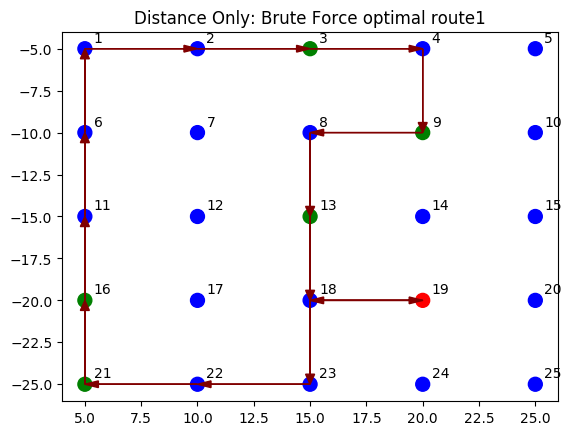

optimal routes:
route 1: [19, 18, 23, 22, 21, 16, 11, 6, 1, 2, 3, 4, 9, 8, 13, 18, 19]


In [10]:
################### plot route ################
function plotRoute(latitude, longtitude, restaurant, customer, scale, optimal_routes_detail_tsp)
    #hold(false)
    x_coords = zeros(1, latitude*longtitude)
    y_coords = zeros(1, latitude*longtitude)
    # plot nodes
    for i  = 1 : latitude
        for j = 1 : longtitude
            y_coords[ (i-1)*latitude + j] = -1*5*i
            x_coords[ (i-1)*latitude + j] = 5*j
        end
    end
    
    scatter(x_coords,y_coords,color=colors, s=100)
    
    for i = 1 : length(optimal_routes_detail_tsp)-1
        cur = optimal_routes_detail_tsp[i]
        next = optimal_routes_detail_tsp[i+1]
        PyPlot.arrow( x_coords[cur], y_coords[cur], x_coords[next]-x_coords[cur] ,y_coords[next]-y_coords[cur], head_width=0.4, length_includes_head=true,color="Maroon")
    end
    
    for i  = 1 : latitude
        for j = 1 : longtitude
            annotate((i-1)*latitude + j, (x_coords[(i-1)*latitude + j]+(scale/20), y_coords[(i-1)*latitude + j]+(scale/20)))
        end
    end
end

for i = 1 : length(optimal_routes_detail)
    plotRoute(latitude, longtitude, restaurant, customer, 8, optimal_routes_detail[i])
    title("Distance Only: Brute Force optimal route$i")
    if i != length(optimal_routes_detail)
        figure()
    end
end

println("optimal routes:")
for i = 1 : length(optimal_routes_detail)
    println("route ",i,": ",optimal_routes_detail[i])
end


In [3]:
#
# option  = {distance_only, distance_vs_order, deadline_require}
#
option = "distance_vs_order"
(optimal_order, optimal_routes_detail, cost_routes, cost_dist, cost_order) = optimalRoute_BF(g, dists, restaurant, customer, desired_order, lambda, Dict(zip(customer, deadline)), option)

println("desired_order: ")
printOrder(nodes, desired_order)
println("cost (cost_dist + cost_order):")
for i = 1 : length(cost_routes)
    println("route ",i,": ",cost_routes[i],"= ",cost_dist[i]," + ",cost_order[i])
end

println("Total cost: ", minimum(cost_routes))
mci = indmin(cost_routes)
println("Tour Trip cost: ", cost_dist[mci])
println("order_cost;", cost_order[mci])
println("lambda:", lambda)
println("optimal order:")
for i = 1 : length(optimal_order)
    println("route ",i,": ",optimal_order[i])
end

println("optimal routes:")
for i = 1 : length(optimal_routes_detail)
    println("route ",i,": ",optimal_routes_detail[i])
end

desired_order: 
19->21->3->9->16->13
cost (cost_dist + cost_order):
route 1: 48.0= 40.0 + 8.0
route 2: 50.0= 42.0 + 8.0
route 3: 60.0= 52.0 + 8.0
route 4: 52.0= 46.0 + 6.0
route 5: 60.0= 54.0 + 6.0
route 6: 50.0= 46.0 + 4.0
route 7: 56.0= 48.0 + 8.0
route 8: 58.0= 50.0 + 8.0
route 9: 70.0= 60.0 + 10.0
route 10: 62.0= 52.0 + 10.0
route 11: 70.0= 62.0 + 8.0
route 12: 60.0= 52.0 + 8.0
route 13: 65.0= 57.0 + 8.0
route 14: 69.0= 63.0 + 6.0
route 15: 67.0= 57.0 + 10.0
route 16: 71.0= 61.0 + 10.0
route 17: 57.0= 51.0 + 6.0
route 18: 57.0= 49.0 + 8.0
route 19: 63.0= 59.0 + 4.0
route 20: 65.0= 63.0 + 2.0
route 21: 65.0= 59.0 + 6.0
route 22: 67.0= 61.0 + 6.0
route 23: 55.0= 51.0 + 4.0
route 24: 55.0= 49.0 + 6.0
route 25: 46.0= 38.0 + 8.0
route 26: 48.0= 40.0 + 8.0
route 27: 55.0= 47.0 + 8.0
route 28: 47.0= 41.0 + 6.0
route 29: 55.0= 49.0 + 6.0
route 30: 45.0= 41.0 + 4.0
route 31: 53.0= 43.0 + 10.0
route 32: 55.0= 45.0 + 10.0
route 33: 64.0= 52.0 + 12.0
route 34: 61.0= 49.0 + 12.0
route 35: 64.0=

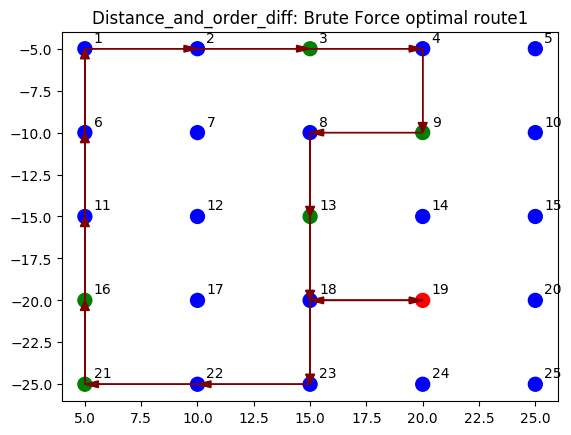

optimal routes:
route 1: [19, 18, 23, 22, 21, 16, 11, 6, 1, 2, 3, 4, 9, 8, 13, 18, 19]


In [9]:
################### plot route ################
function plotRoute(latitude, longtitude, restaurant, customer, scale, optimal_routes_detail_tsp)
    hold(false)
    x_coords = zeros(1, latitude*longtitude)
    y_coords = zeros(1, latitude*longtitude)
    # plot nodes
    for i  = 1 : latitude
        for j = 1 : longtitude
            y_coords[ (i-1)*latitude + j] = -1*5*i
            x_coords[ (i-1)*latitude + j] = 5*j
        end
    end
    
    scatter(x_coords,y_coords,color=colors, s=100)
    
    for i = 1 : length(optimal_routes_detail_tsp)-1
        cur = optimal_routes_detail_tsp[i]
        next = optimal_routes_detail_tsp[i+1]
        PyPlot.arrow( x_coords[cur], y_coords[cur], x_coords[next]-x_coords[cur] ,y_coords[next]-y_coords[cur], head_width=0.4, length_includes_head=true,color="Maroon")
    end
    
    for i  = 1 : latitude
        for j = 1 : longtitude
            annotate((i-1)*latitude + j, (x_coords[(i-1)*latitude + j]+(scale/20), y_coords[(i-1)*latitude + j]+(scale/20)))
        end
    end
end

for i = 1 : length(optimal_routes_detail)
    plotRoute(latitude, longtitude, restaurant, customer, 8, optimal_routes_detail[i])
    title("Distance_and_order_diff: Brute Force optimal route$i")
    if i != length(optimal_routes_detail)
        figure()
    end
end

println("optimal routes:")
for i = 1 : length(optimal_routes_detail)
    println("route ",i,": ",optimal_routes_detail[i])
end

As the name indicated, Our Brute Force method enumerates all the possible traveling orders and compute the cost for each order respectively. The drawback of Brute Force method is that the complexity grows factorially as number of node increases. The Brute Force method is guaranteed to return the optimal solution regardelss how the cost is computed.

## Traveling Salesman Problem 

We model the delivery route problem using the model of the traveling salesman problem (TSP) to find the optimal route that minimizes the trip cost for the restaurant delivery. In the first part, we solve the problem by minimize the total trip cost from restaurant to customers and then back to the restaurant. In the second part, we generated a desired order of delivery schedule which is equivalent to the maximal customer satisfactory schedule. We solve the TSP problem with a tradeoff between minimize trip cost and maximize customer satisfaction by matching the desired order of delivery. We use L1 norm of delivery order difference as the measurement of satisfactory cost.

### Mathematicl Model

### 1. Data known for modeling
#### Preprocessing map data
The original map includes three types of nodes, i,e, restaurant node, customer node, and other nodes. Restaurant and customer node must be visited, whereas the other node may nor may not be visited, depending on whether visiting it would decrease the cost or not. In order to model our problem as typical TSP in which all the nodes must be visited, we make the following modifications on our original map data:
                                        
                                        For each node that must be visited:
                                            $c_{ij}$ = dijkstra(i,j)
                                        
Then we will obtain a graph with only restaurant and customer nodes, and the edges are replaced by the shortest distance returned by dijkstra's algorithm. 
#### Trip Cost

Assume we have N-1 customers and a departing restaurant, we have a total of N sites that we need visit along the optimal cost route. The cost matrix is obtained by by dijkstra's algorithm in the preprocessing step. The cost from site i to site i is zero. The cost ranges from 0 to 100 in our model.

<center>$c_{ij}$ = cost driving from site i to site j</center>


For each $c_{ij}$ in cell, i is row number and j is column number. Table below is an example of distance matrix. 

| **Site From \ Site To**|  1 |  2 |  3 |  4 |  5 |  6  |  7 |  8 |  9 | 10 |
|:----------------------:|:--:|:--:|:--:|:--:|:--:|:---:|:--:|:--:|:--:|:--:|
|          **1**         |  0 | 81 | 95 | 76 | 58 |  12 |  4 | 74 | 55 |  2 |
|          **2**         | 81 |  0 | 70 | 30 | 72 |  63 |  3 | 46 | 23 |  5 |
|          **3**         | 95 | 70 |  0 |  4 | 42 | 100 | 60 | 46 | 75 | 47 |
|          **4**         | 76 | 30 | 4  |  0 | 82 |  47 | 36 | 91 | 40 | 95 |
|          **5**         | 58 | 72 | 42 | 82 |  0 |  88 | 80 | 11 | 15 | 89 |
|          **6**         | 12 | 63 | 100| 47 | 88 |  0  |  2 | 34 | 68 | 43 |
|          **7**         | 4  | 3  | 60 | 36 | 80 |  2  |  0 | 64 | 68 | 17 |
|          **8**         | 74 | 46 | 46 | 91 | 11 |  34 | 64 |  0 |  5 | 41 |
|          **9**         | 55 | 23 | 75 | 40 | 15 |  68 | 68 | 5  |  0 | 75 |
|          **10**        | 2  | 5  | 47 | 95 | 89 |  17 | 17 | 41 | 75 |  0 |

#### Expected order

To add trade off parameter in the model, we randomly generated an expected order $E(i)$ of delivery for each site $i \in [1,N]$. Site 1 is restaurant so it always has 1 as expected order and also in the final model as an constraint. Table below is an example of expected delivery order.





| **Sites **                  $ i $       | 1  | 2  | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|:---------------------------------------:|----|----|---|---|---|---|---|---|---|----|
| **Expected Delivery Order** $E (i) $    | 1  | 10 | 8 | 2 | 9 | 4 | 7 | 6 | 3 | 5  |


### 2. Variable Definition

* We define a N by N matrix x such that, the rows and columns correspond to sites that we need include in the route. The MTZ solution will give us a cyclic route that visits every site appear exactly once.  

$$  x_{i,j}= \begin{cases} 
1 & \text{if we choose to include the trip from site i to site j in the optimal route} \\
0 & \text{otherwise}
\end{cases} \hspace{10mm}
\text{for i, j } \in [1,N]$$

* We define an optimal order of delivery $o_i \forall i \in N$ represents the delivery order for site i in the optimal delivery route.
   
### 3. Objective Function

* Objective: Minimize Total Cost. $$\underset{x}{\mathrm{argmin}}   \sum_{j=1}^N c_{ij}x_{ij} + \sum_{k=1}^N |E_k - o_k|$$
<br>
* Total Cost = Total Trip Cost + Total Satisfaction Cost
<br>
    $$\text{Total Trip Cost =  }\sum_{j=1}^N c_{ij} x_{ij} $$
    $$\text{Total Satisfaction Cost = }\sum_{k=1}^N \text{Satisfaction Cost k } = \sum_{k=1}^N |E_k - o_k| $$


### 4. Constraint

* One arc entering each node: $$ \sum_{i \in N} x_{ij} = 1 \hspace{3mm} \forall j \in N $$
* One arc leaving each node: $$ \sum_{j \in N} x_{ij} = 1 \hspace{3mm} \forall i \in N $$
* No self-loops: $$x_{ii} = 0 \hspace{3mm} \forall i \in N $$
<br>
* Binary variable: $$x_{ij} \in {0,1} \hspace{3mm} \forall i \in N, j \in N$$
<br>
* No subtours: $\text{If }x_{ij} = 1\text{, then }o_j > o_i\text{, since we go to site j from site i, we must deliver to site j after site i.}$

$$1 \leq o_i \leq n \hspace{3mm} \forall i \in N $$
$$o_i - o_j + nx_{ij} \leq n-1 \hspace{3mm} \forall i\in N, j\in N,j \neq 1$$

* Satisfaction cost:  <br>
$$ \text{satisfaction_cost} \geq E_k - o_k \hspace{3mm}\forall k \in N$$
$$\text{satisfaction_cost} \geq o_k - E_k \hspace{3mm}\forall k \in N$$



## TSP Implementation and Solution 

We implement and solve the model with and without the tradeoff. In the first case, we don't consider the traveling order on the route. The objective is to minimize the traveling distance. In the second case, we take traveling order into consideration, where we desire to minimize the traveling distance as well as matching the expected traveling order. 

First, we run the TSP implementation with the same data in the Brute Force method to confirm the two algorithmas obtain the same result. Then TSP implementation is ran over a larger map with more nodes. 

We first plot the original map. Then solve TSP, and print the optimal route and cost. Finally, we plot the optimal route on the map. In the case with the trade off, we also plot the Pareto curve 

cost graph of the map:

 0   2   C1   7   0   3   C2  

 6       6       3       8      

 0   8   C3   3   0   6   0  

 2       3       5       6      

 0   6   0   5   R   5   0  

 1       3       5       5      

 C4   6   0   1   0   6   0  

desired_order: 
11->2->4->13->6
Academic license - for non-commercial use only
Tour Trip cost: 

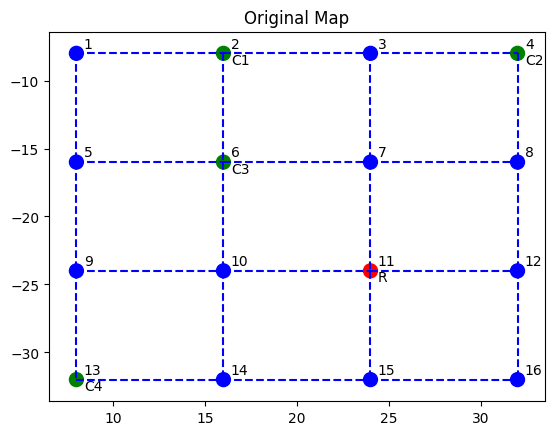

50.0
order_cost;2.0
Total cost: 52.0
optimal order:Any[11, 4, 2, 13, 6, 11]
optimal routes:[11, 7, 3, 4, 3, 2, 1, 5, 9, 13, 9, 10, 6, 10, 11]


In [4]:
using Graphs, NamedArrays, Clp, Combinatorics, Gurobi, JuMP, PyPlot

#################Generate map####################
seed = srand(42453)

# Parameters
latitude = 4
longtitude = 4
density = 0.2
time_length = 200
max_tip = 10
# ------------

vertical = 1
horizontal = 2

c = zeros(latitude, longtitude)  # Mark all nodes as normal nodes
time = zeros(latitude, longtitude)
cost = 2*time_length*ones(latitude, longtitude, 2)

tips = zeros(latitude, longtitude)

R = (ceil(Int64, rand() * latitude), ceil(Int64, rand() * longtitude))
c[R[1], R[2]] = 2 #generating Restaurant
customer_number = 0

while customer_number < ceil(density * latitude * longtitude)
    xx = ceil(Int64, rand() * latitude)
    yy = ceil(Int64, rand() * longtitude)
    if c[xx, yy] == 0
        c[xx, yy] = 1
        time[xx, yy] = ceil(rand() * time_length);
        tips[xx, yy] = ceil(rand() * max_tip);
        customer_number = customer_number + 1
    end
end

customer_n = 0
paths = 1
dists = Array{Int64}((longtitude-1)*latitude + longtitude*(latitude-1))
#customer = Array{Tuple(Int64, Int64)}(latitude*longtitude*density)
restaurant = 1
customer = Array{Int64}(ceil(Int64,longtitude*latitude*density))
tip = Array{Int64}(ceil(Int64,longtitude*latitude*density))
deadline = Array{Int64}(ceil(Int64,longtitude*latitude*density))

g = simple_inclist(latitude*longtitude, is_directed=false)

#add vertex and edge according to the map index.
for i in 1:latitude
    for j in 1:longtitude
        if c[i, j] == 1
            customer_n = customer_n + 1
            customer[customer_n] = (i-1)*longtitude+j
            tip[customer_n] = tips[i, j]
            deadline[customer_n] = time[i, j]
        end
        if c[i, j] == 2
            restaurant = (i-1)*longtitude+j
        end
        if i != latitude #generate the cost of each legal route
            cost[i, j, vertical] = ceil(Int64, rand() * time_length/(latitude*longtitude)*((1-density).^2))
            add_edge!(g, (i-1)*longtitude + j, i*longtitude + j)
            dists[paths] = cost[i, j, vertical]
            paths = paths + 1
        end
        if j != longtitude
            cost[i, j, horizontal] = ceil(Int64, rand() * time_length/(latitude*longtitude)*((1-density).^2))
            add_edge!(g, (i-1)*longtitude + j, (i-1)*longtitude + j + 1)
            dists[paths] = cost[i, j, horizontal]
            paths = paths + 1
        end
    end
end

@printf("cost graph of the map:")
customer_number = 1
colors = [] # restaurant-r  customer-g others-b

for i in 1:latitude
    if i != 1
        for j in 1:longtitude
            @printf("%2.d      ", cost[i-1, j, vertical])
        end
    end
    @printf("\n\n")
    for j in 1:longtitude
        if c[i, j] == 1
            push!(colors,"g")
            @printf(" C%d  ",customer_number)
            customer_number = customer_number + 1
        end
        if c[i, j] == 2
            push!(colors,"r")
            @printf(" R  ")
        end
        if c[i, j] == 0
            push!(colors,"b")
            @printf(" 0  ")
        end
        if j != longtitude
            @printf("%2.d  ", cost[i, j, horizontal]);
        end
    end
    @printf("\n\n")
end


#restaurant is saved at index customer_n+1
#distance_matrix = zeros(customer_n + 1, customer_n + 1)
#customer[customer_n+1] = restaurant

#for i = 1:customer_n+1
#    for j = 1:customer_n+1
#        path = dijkstra_shortest_paths(g, dists, customer[i])
#    end
#end

# generate random order starting from restaurant
nodes = [restaurant; customer]
N = length(nodes)
random_order = randperm(N-1)+1

desired_order = Dict()
desired_order[nodes[1]] = 1
for i = 2 : N
    desired_order[nodes[i]] = random_order[i-1]
end

#println("my desired_order:")
#for (pp,qq) in desired_order
#    println("$pp-> $qq")
#end
function printOrder(nodes, desired_order)
    order = 1
    for i = 1 : N
        for j = 1 : N
            cur_order = desired_order[nodes[j]]
            if(cur_order == order)
                if(i < N)
                    print(nodes[j],"->")
                else
                    print(nodes[j])
                    println()
                end
                order = order + 1
                break
            end
        end
    end
end
println("desired_order: ")
printOrder(nodes, desired_order)

###########plot graph############################
function plotGraph(latitude, longtitude, restaurant, customer,scale)
    x_coords = zeros(1, latitude*longtitude)
    y_coords = zeros(1, latitude*longtitude)
    # plot nodes
    for i  = 1 : latitude
        for j = 1 : longtitude
            y_coords[ (i-1)*latitude + j] = -1*scale*i
            x_coords[ (i-1)*latitude + j] = scale*j
        end
    end
    # plot horizontal edge
    for i = 1 : latitude
        for j = 1 : longtitude-1
            PyPlot.plot( [ x_coords[(i-1)*latitude+j], x_coords[(i-1)*latitude+j+1] ], [ y_coords[(i-1)*latitude+j], y_coords[(i-1)*latitude+j+1] ],"b--")
        end
    end

    #plot vertical edge
    for j = 1 : longtitude
        for i = 1 : latitude-1
            PyPlot.plot([x_coords[(i-1)*latitude+j], x_coords[(i)*latitude+j] ],[y_coords[(i-1)*latitude+j], y_coords[(i)*latitude+j]], "b--"  )
        end
    end


    gs = scatter(x_coords,y_coords,color=colors, s=100)
    # plot annotate

    annotate("R", (x_coords[restaurant]+(scale/20), y_coords[restaurant]-(scale/10)))
    for i = 1 : length(customer)
        cur = customer[i]
        annotate("C$i", (x_coords[cur]+(scale/20), y_coords[cur]-(scale/10)))
    end
    
    for i  = 1 : latitude
        for j = 1 : longtitude
            annotate((i-1)*latitude + j, (x_coords[(i-1)*latitude + j]+(scale/20), y_coords[(i-1)*latitude + j]+(scale/20)))
        end
    end
    title("Original Map")
end

plotGraph(latitude, longtitude, restaurant, customer, 8)

#################################################

# first is restaurant. Remaining is customer
lambda = 1

function optimal_route_tsp(g, dists, nodes, desired_order, lambda, option)
    sites = 1:length(nodes)
    N = length(sites)
    trip_cost = zeros(length(nodes),length(nodes))

    for i = 1 : length(nodes)
        shortest_paths = dijkstra_shortest_paths(g, dists, nodes[i])
        for j = 1 : length(nodes)
            trip_cost[i,j] = shortest_paths.dists[nodes[j]]
        end
    end

    site_to_node = Dict()

    for i = 1 : N
        site_to_node[i] = nodes[i]
    end

    order = Dict()
    for i = 1 : N
        order[sites[i]] = desired_order[nodes[sites[i]]]
    end
    
    if option == "dist_vs_order"
        m = Model(solver = GurobiSolver(OutputFlag=0))

        @variable(m, x[sites,sites] >= 0, Bin)   # must formulate as IP this time

        @constraint(m, c1[j in sites], sum( x[i,j] for i in sites ) == 1)      # one out-edge
        @constraint(m, c2[i in sites], sum( x[i,j] for j in sites ) == 1)      # one in-edge
        @constraint(m, c3[i in sites], x[i,i] == 0 )                            # no self-loops
        @constraint(m, c4[j in sites], sum( x[i,j] for i in sites ) == sum( x[j,k] for k in sites ))      # one out-edge

        # MTZ variables and constraints
        @variable(m, new_order[sites] >=1, Int)
        @constraint(m, c5[i in sites, j in sites[2:end]], new_order[i] - new_order[j] + N*x[i,j] <= N-1 )

        # trade off of tips loss
        @variable(m, order_diff[sites])
        @variable(m, L1_order[sites] >=0)
        @variable(m, total_trip_cost >=0)

        @constraint(m, c6[i in sites], order_diff[i] == new_order[i] - order[i])
        @constraint(m, c7[i in sites], L1_order[i] >= order_diff[i])
        @constraint(m, c8[i in sites], L1_order[i] >= - order_diff[i])
        @constraint(m, total_trip_cost == sum(x[i,j] * trip_cost[i,j] for i in sites, j in sites))

        @objective(m, Min, total_trip_cost + lambda * sum(L1_order))   # minimize total cost

        status = solve(m)
        
        optimal_order_tsp = []
        # get optimal order
        #for i in sites
        #    push!(optimal_order_tsp, site_to_node[ getvalue(new_order[i])] )
        #end

        next = 1
        push!(optimal_order_tsp,site_to_node[next])
        for i = 1:length(sites)-1
            # println("i = ", i)
            for j = 1:length(sites)
                # println("j = ", j)
                if getvalue(x[sites[next],sites[j]]) == 1
                    push!(optimal_order_tsp,site_to_node[j])
                    next = j
                    break
                end
            end
        end
        push!(optimal_order_tsp, site_to_node[1])

        #get optimal detailed order
        optimal_routes_detail_tsp = []
        for i = 1 : length(optimal_order_tsp)
            if i < length(optimal_order_tsp)
                cur_node = optimal_order_tsp[i]
                next_node = optimal_order_tsp[i+1]
                # obtain the specific traverse order in the shortest path recorded in Dijkstra's Algorithm
                shortest_path = dijkstra_shortest_paths(g, dists,cur_node)
                paths = enumerate_paths(vertices(g),shortest_path.parent_indices)
                if (length(optimal_routes_detail_tsp) == 0)
                    optimal_routes_detail_tsp = paths[next_node]
                else
                    optimal_routes_detail_tsp = [optimal_routes_detail_tsp ; paths[next_node][2:end]]
                end
            end
        end
        return (optimal_order_tsp, optimal_routes_detail_tsp, getobjectivevalue(m), getvalue(total_trip_cost), getvalue(sum(L1_order)))
    elseif option == "dist"
         m = Model(solver = GurobiSolver(OutputFlag=0))

        @variable(m, x[sites,sites] >= 0, Bin)   # must formulate as IP this time

        @constraint(m, c1[j in sites], sum( x[i,j] for i in sites ) == 1)      # one out-edge
        @constraint(m, c2[i in sites], sum( x[i,j] for j in sites ) == 1)      # one in-edge
        @constraint(m, c3[i in sites], x[i,i] == 0 )                            # no self-loops
        @constraint(m, c4[j in sites], sum( x[i,j] for i in sites ) == sum( x[j,k] for k in sites ))

        # MTZ variables and constraints
        @variable(m, new_order[sites] >=1, Int)
        @constraint(m, c5[i in sites, j in sites[2:end]], new_order[i] - new_order[j] + N*x[i,j] <= N-1 )


        @objective(m, Min, sum(x[i,j] * trip_cost[i,j] for i in sites, j in sites))   # minimize total cost

        status = solve(m)
        optimal_order_tsp = []
        # get optimal order
        #for i in sites
        #    push!(optimal_order_tsp, site_to_node[ getvalue(new_order[i])] )
        #end

        next = 1
        push!(optimal_order_tsp,site_to_node[next])
        for i = 1:length(sites)-1
            # println("i = ", i)
            for j = 1:length(sites)
                # println("j = ", j)
                if getvalue(x[sites[next],sites[j]]) == 1
                    push!(optimal_order_tsp,site_to_node[j])
                    next = j
                    break
                end
            end
        end
        push!(optimal_order_tsp, site_to_node[1])

        #get optimal detailed order
        optimal_routes_detail_tsp = []
        for i = 1 : length(optimal_order_tsp)
            if i < length(optimal_order_tsp)
                cur_node = optimal_order_tsp[i]
                next_node = optimal_order_tsp[i+1]
                # obtain the specific traverse order in the shortest path recorded in Dijkstra's Algorithm
                shortest_path = dijkstra_shortest_paths(g, dists,cur_node)
                paths = enumerate_paths(vertices(g),shortest_path.parent_indices)
                if (length(optimal_routes_detail_tsp) == 0)
                    optimal_routes_detail_tsp = paths[next_node]
                else
                    optimal_routes_detail_tsp = [optimal_routes_detail_tsp ; paths[next_node][2:end]]
                end
            end
        end
        return (optimal_order_tsp, optimal_routes_detail_tsp, getobjectivevalue(m), getobjectivevalue(m), 0)
    else
        println("Should not happen");
        return
    end
    
end


(optimal_order_tsp,optimal_routes_detail_tsp,toc,tc,oc) =  optimal_route_tsp(g, dists, nodes, desired_order,1, "dist_vs_order")
println("Tour Trip cost: ", round(tc,4))
println("order_cost;", sum(oc))
println("Total cost: ", round(toc,4))
println("optimal order:",optimal_order_tsp)
println("optimal routes:",optimal_routes_detail_tsp)



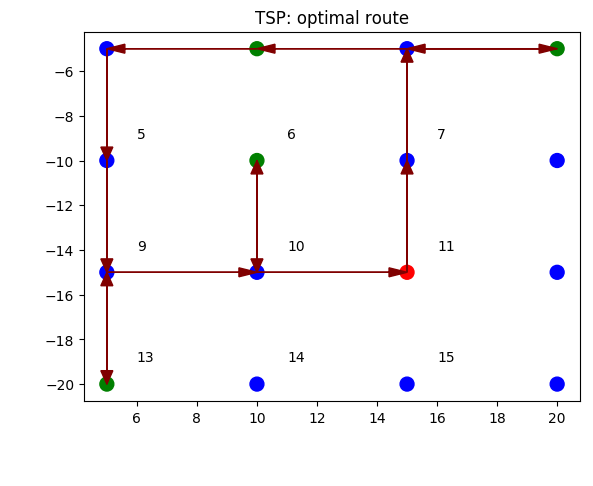

PyObject <matplotlib.text.Text object at 0x1318e6950>

In [6]:
################### plot route ################
function plotRoute(latitude, longtitude, restaurant, customer, scale, optimal_routes_detail_tsp)
    #hold(false)
    x_coords = zeros(1, latitude*longtitude)
    y_coords = zeros(1, latitude*longtitude)
    # plot nodes
    for i  = 1 : latitude
        for j = 1 : longtitude
            y_coords[ (i-1)*latitude + j] = -1*5*i
            x_coords[ (i-1)*latitude + j] = 5*j
        end
    end
    
    scatter(x_coords,y_coords,color=colors, s=100)
    
    for i = 1 : length(optimal_routes_detail_tsp)-1
        cur = optimal_routes_detail_tsp[i]
        next = optimal_routes_detail_tsp[i+1]
        PyPlot.arrow( x_coords[cur], y_coords[cur], x_coords[next]-x_coords[cur] ,y_coords[next]-y_coords[cur], head_width=0.4, length_includes_head=true,color="Maroon")
    end
    
    for i  = 1 : latitude
        for j = 1 : longtitude
            annotate((i-1)*latitude + j, (x_coords[(i-1)*latitude + j]+(scale/8), y_coords[(i-1)*latitude + j]+(scale/8)))
        end
    end
    title("TSP: optimal route")
end

plotRoute(latitude, longtitude, restaurant, customer, 8, optimal_routes_detail_tsp)

cost graph of the map:

 0   2   0   2   C1   2   0   2   0   1   C2   1   0   2   0  

 1       2       2       2       1       1       1       1      

 0   1   0   1   0   1   C3   1   0   2   0   2   C4   1   0  

 2       2       1       1       1       1       1       1      

 0   1   0   2   C5   2   0   2   0   2   0   1   0   2   0  

 2       1       2       1       2       2       1       1      

 0   1   0   1   0   2   0   2   0   1   0   1   0   1   0  

 2       2       1       1       2       2       1       2      

 0   1   0   2   0   1   C6   1   C7   1   C8   2   0   2   0  

 2       1       1       1       1       2       2       2      

 0   1   C9   2   0   1   C10   2   0   2   R   2   0   1   0  

 2       2       1       1       2       2       1       1      

 C11   1   0   2   C12   1   0   1   0   2   0   1   0   2   0  

 1       2       1       2       1       2       2       2      

 0   2   0   2   C13   1   0   2   0   1   0   2   0   2   0  

d

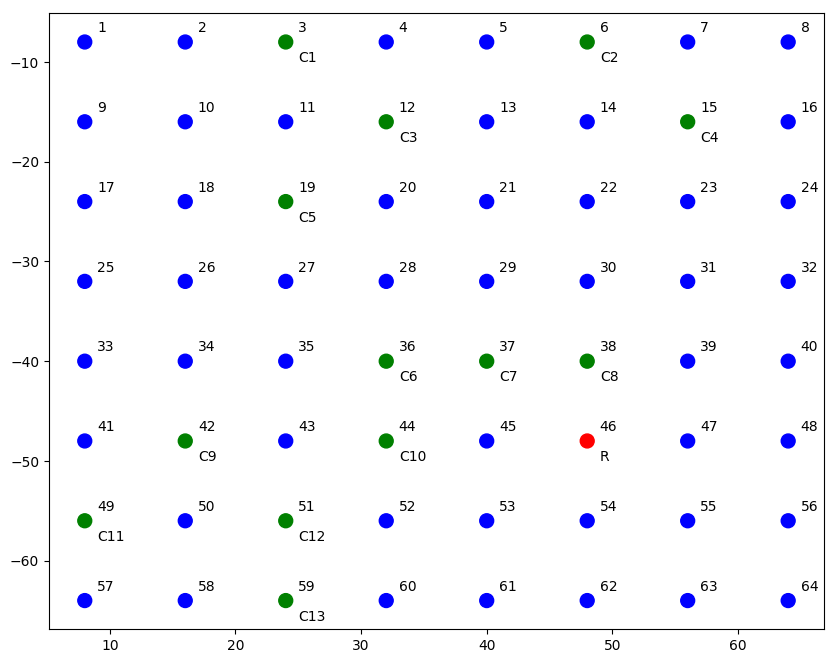

Tour Trip cost: 52.0
order_cost;12.0
Total cost: 64.0
optimal order:Any[46, 38, 44, 51, 59, 42, 19, 3, 6, 15, 12, 36, 49, 37, 46]
optimal routes:[46, 38, 37, 36, 44, 43, 51, 59, 51, 43, 42, 34, 26, 18, 19, 11, 3, 4, 5, 6, 7, 15, 14, 13, 12, 20, 28, 36, 35, 43, 51, 50, 49, 50, 51, 43, 35, 36, 37, 38, 46]



In [7]:
using Graphs, NamedArrays, Clp, Combinatorics, Gurobi, JuMP, PyPlot

#################Generate map####################
seed = srand(42453)

# Parameters
latitude = 8
longtitude = 8
density = 0.2
time_length = 200
max_tip = 10
# ------------

vertical = 1
horizontal = 2

c = zeros(latitude, longtitude)  # Mark all nodes as normal nodes
time = zeros(latitude, longtitude)
cost = 2*time_length*ones(latitude, longtitude, 2)

tips = zeros(latitude, longtitude)

R = (ceil(Int64, rand() * latitude), ceil(Int64, rand() * longtitude))
c[R[1], R[2]] = 2 #generating Restaurant
customer_number = 0

while customer_number < ceil(density * latitude * longtitude)
    xx = ceil(Int64, rand() * latitude)
    yy = ceil(Int64, rand() * longtitude)
    if c[xx, yy] == 0
        c[xx, yy] = 1
        time[xx, yy] = ceil(rand() * time_length);
        tips[xx, yy] = ceil(rand() * max_tip);
        customer_number = customer_number + 1
    end
end

customer_n = 0
paths = 1
dists = Array{Int64}((longtitude-1)*latitude + longtitude*(latitude-1))
#customer = Array{Tuple(Int64, Int64)}(latitude*longtitude*density)
restaurant = 1
customer = Array{Int64}(ceil(Int64,longtitude*latitude*density))
tip = Array{Int64}(ceil(Int64,longtitude*latitude*density))
deadline = Array{Int64}(ceil(Int64,longtitude*latitude*density))

g = simple_inclist(latitude*longtitude, is_directed=false)

#add vertex and edge according to the map index.
for i in 1:latitude
    for j in 1:longtitude
        if c[i, j] == 1
            customer_n = customer_n + 1
            customer[customer_n] = (i-1)*longtitude+j
            tip[customer_n] = tips[i, j]
            deadline[customer_n] = time[i, j]
        end
        if c[i, j] == 2
            restaurant = (i-1)*longtitude+j
        end
        if i != latitude #generate the cost of each legal route
            cost[i, j, vertical] = ceil(Int64, rand() * time_length/(latitude*longtitude)*((1-density).^2))
            add_edge!(g, (i-1)*longtitude + j, i*longtitude + j)
            dists[paths] = cost[i, j, vertical]
            paths = paths + 1
        end
        if j != longtitude
            cost[i, j, horizontal] = ceil(Int64, rand() * time_length/(latitude*longtitude)*((1-density).^2))
            add_edge!(g, (i-1)*longtitude + j, (i-1)*longtitude + j + 1)
            dists[paths] = cost[i, j, horizontal]
            paths = paths + 1
        end
    end
end

@printf("cost graph of the map:")
customer_number = 1
colors = [] # restaurant-r  customer-g others-b

for i in 1:latitude
    if i != 1
        for j in 1:longtitude
            @printf("%2.d      ", cost[i-1, j, vertical])
        end
    end
    @printf("\n\n")
    for j in 1:longtitude
        if c[i, j] == 1
            push!(colors,"g")
            @printf(" C%d  ",customer_number)
            customer_number = customer_number + 1
        end
        if c[i, j] == 2
            push!(colors,"r")
            @printf(" R  ")
        end
        if c[i, j] == 0
            push!(colors,"b")
            @printf(" 0  ")
        end
        if j != longtitude
            @printf("%2.d  ", cost[i, j, horizontal]);
        end
    end
    @printf("\n\n")
end


# generate random order starting from restaurant
nodes = [restaurant; customer]
N = length(nodes)
random_order = randperm(N-1)+1

desired_order = Dict()
desired_order[nodes[1]] = 1
for i = 2 : N
    desired_order[nodes[i]] = random_order[i-1]
end

#println("my desired_order:")
#for (pp,qq) in desired_order
#    println("$pp-> $qq")
#end
function printOrder(nodes, desired_order)
    order = 1
    for i = 1 : N
        for j = 1 : N
            cur_order = desired_order[nodes[j]]
            if(cur_order == order)
                if(i < N)
                    print(nodes[j],"->")
                else
                    print(nodes[j])
                    println()
                end
                order = order + 1
                break
            end
        end
    end
end
println("desired_order: ")
printOrder(nodes, desired_order)

###########plot graph############################
function plotGraph(latitude, longtitude, restaurant, customer,scale)
    x_coords = zeros(1, latitude*longtitude)
    y_coords = zeros(1, latitude*longtitude)
    # plot nodes
    for i  = 1 : latitude
        for j = 1 : longtitude
            y_coords[ (i-1)*latitude + j] = -1*scale*i
            x_coords[ (i-1)*latitude + j] = scale*j
        end
    end

    figure(figsize=(10,8))
    # plot horizontal edge
    for i = 1 : latitude
        for j = 1 : longtitude-1
            PyPlot.plot( [ x_coords[(i-1)*latitude+j], x_coords[(i-1)*latitude+j+1] ], [ y_coords[(i-1)*latitude+j], y_coords[(i-1)*latitude+j+1] ],"b--")
        end
    end

    #plot vertical edge
    for j = 1 : longtitude
        for i = 1 : latitude-1
            PyPlot.plot([x_coords[(i-1)*latitude+j], x_coords[(i)*latitude+j] ],[y_coords[(i-1)*latitude+j], y_coords[(i)*latitude+j]], "b--"  )
        end
    end


    gs = scatter(x_coords,y_coords,color=colors, s=100)
    # plot annotate

    annotate("R", (x_coords[restaurant]+(scale/8), y_coords[restaurant]-(scale/4)))
    for i = 1 : length(customer)
        cur = customer[i]
        annotate("C$i", (x_coords[cur]+(scale/8), y_coords[cur]-(scale/4)))
    end
    
    for i  = 1 : latitude
        for j = 1 : longtitude
            annotate((i-1)*latitude + j, (x_coords[(i-1)*latitude + j]+(scale/8), y_coords[(i-1)*latitude + j]+ (scale/8)))
        end
    end
end

plotGraph(latitude, longtitude, restaurant, customer, 8)

#################################################

# first is restaurant. Remaining is customer
lambda = 1

(oo_tsp,rt_tsp,toc,tc,oc) =  optimal_route_tsp(g, dists, nodes, desired_order,lambda, "dist_vs_order")
println()
println("Tour Trip cost: ", round(tc,4))
println("order_cost;", sum(oc))
println("Total cost: ", round(toc,4))
println("optimal order:",oo_tsp)
println("optimal routes:",rt_tsp)
println()

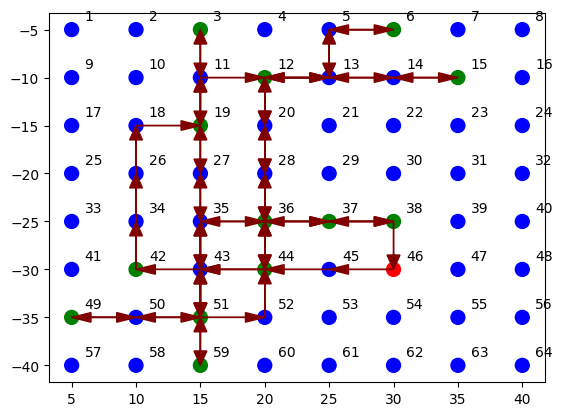

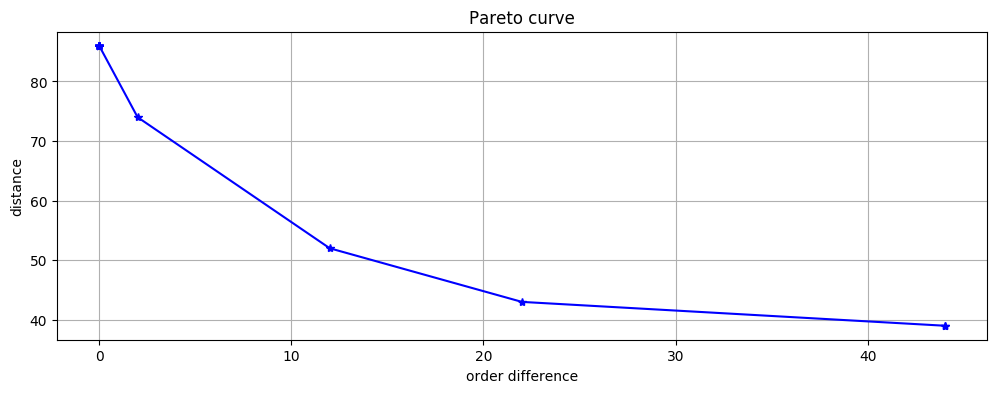

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only

trip_cost[39.0 39.0 43.0 52.0 74.0 86.0 86.0 86.0 86.0 86.0 86.0 86.0 86.0 86.0 86.0 86.0 86.0]
order_cost[44.0 44.0 22.0 12.0 2.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


In [8]:
################### plot route ################
function plotRoute(latitude, longtitude, restaurant, customer, scale, optimal_routes_detail_tsp)
    hold(false)
    x_coords = zeros(1, latitude*longtitude)
    y_coords = zeros(1, latitude*longtitude)
    # plot nodes
    for i  = 1 : latitude
        for j = 1 : longtitude
            y_coords[ (i-1)*latitude + j] = -1*5*i
            x_coords[ (i-1)*latitude + j] = 5*j
        end
    end
    scatter(x_coords,y_coords,color=colors, s=100)
    
    for i = 1 : length(optimal_routes_detail_tsp)-1
        cur = optimal_routes_detail_tsp[i]
        next = optimal_routes_detail_tsp[i+1]
        PyPlot.arrow( x_coords[cur], y_coords[cur], x_coords[next]-x_coords[cur] ,y_coords[next]-y_coords[cur], head_width=1, length_includes_head=true,color="Maroon")
    end
    
    for i  = 1 : latitude
        for j = 1 : longtitude
            annotate((i-1)*latitude + j, (x_coords[(i-1)*latitude + j]+(scale/8), y_coords[(i-1)*latitude + j]+(scale/8)))
        end
    end
end

plotRoute(latitude, longtitude, restaurant, customer, 8, rt_tsp)


######################Tradeoff ###################
# option can be "dist_vs_order" or "dist"
lmd = [0.05, 0.1,0.5,1,5,10,20,40,80,150,300,500,700,1000,1500,3000,5000]
trip_cost = zeros(1,length(lmd))
order_cost = zeros(1,length(lmd))
totol_cost = zeros(1,length(lmd))
for i  = 1 : length(lmd)
    (oo_tsp,rt_tsp,toc,tc,oc) =  optimal_route_tsp(g, dists, nodes, desired_order,lmd[i], "dist_vs_order")
    trip_cost[i] = tc
    order_cost[i] = oc
    totol_cost[i] = toc
end
println()
println("trip_cost",trip_cost)
println("order_cost",order_cost)

figure(figsize=(12,4))
p1 = PyPlot.plot(order_cost[:], trip_cost[:],"b*-")
ylabel("distance")
xlabel("order difference")
title("Pareto curve")
grid()

Using TSP model can solve problem with a larger number of customers than BF model. In the TSP model, when we increase the value of lambda, the optimal delivery order will get closer to expected delivery order, and eventually become the same, as we value the importance of delivery time much more than the trip cost. 

## Vehicle Routing Model
The previous models are designed for 1 vehicle. However, when things come to the reality, it is more practical if we can figure out the routine for MULTIPLE vehicles. Imagine we have k vehicles and 5 customers that requested different amounts of deliveries. Each truck has a Vehicle_Max_Capacity of 30 units, which means each individual vehicle can not cover all the customers on a routine if the total request of that particular routine is bigger than 30 units. In other words, another truck is necessary to help its partner out ---- That is, cover the rest of the customers.
### Vehicle Routing Mathematicl Model###
#### 1. Data Known for modeling 
1. Number of Vehicles == "k"
2. Amount of Customers == 5
3. Vehicle_Max_Capacity == 30
5. Request from each Customers == Customers_Request (see line 15 in code section for this model)

#### 2. Variables: 

$$  z_ = \begin{cases} 
1 & \text{if we choose to include this trip} \\
0 & \text{otherwise}
\end{cases} \hspace{10mm}
\text{for z } \in [Routines]$$

#### 3. Constraints: 


$$st. \sum_{r=1}^{R} a_{ri}z_r \;\; \forall r \in R \;\; z_r \in \{ 0,1 \}$$<br>

$$\forall i=1,...,n \text{ (In our case n=5)}\\
\text{Where } a_{ri} = 1 \text{if route r visits customer i, and 0 otherwise}$$
    
#### 4. Objective: ####
$$\min_z \sum^{|R|}_{r = 1} z_r$$<br>
Find the **Minimum Set of Routines** that covers ***every single Customer***.

### Vehicle Routine Implementation and Solution ###
We set up routines based on the ***Vehicle_Max_Capacity***. Some routines are not available due to the **30 units limitation** of ***Vehicle_Max_Capacity***. We let the code generate all possible routines automatically and save them into ***Actual_Routines***

We use the concept of ***Set Covering*** in this case to ensure every single customer can be covered while **MINIMIZING the amount of sets.**

In [3]:
using JuMP, Gurobi, NamedArrays, Combinatorics

m = Model(solver = GurobiSolver(OutputFlag=0))

Vehicle_Max_Capacity = 30 # max capacity of each Truck

Routines = Array[]
Routines_tp = Array[]
Actual_Routines = Array[]
Cost_Array = Int64[]
Coverage_Array = Array[]
Cover_Counter_Array = Int64[]

Customers = [0,1,2,3,4,5]
Customers_Request = Dict(zip(Customers, [0 11 9 8 12 14]))
f = 0 # Counter --- useless
x = 0 # Counter --- useless

Distances_D_M = NamedArray([0 18 14 16 12 19
                            18 0 18 30 26 28
                            14 18 0 20 22 21
                            16 30 20 0 22 21
                            12 26 22 22 0 22
                            19 28 21 21 22 0],(Customers,Customers),("Customers","Customers"))

######### Gather All of the Routines and put them into an Array ###############
ppl = length(Customers)-1 # the first element is restaurant
for i in 2:length(Customers)
    Routines_tp = collect(permutations(Customers[2:end],ppl))
    push!(Routines,Routines_tp)
    ppl = ppl - 1
end

########## Get the Actual Routines that are possible to implement #############

for i in 1:length(Routines) # largest Array
    for k in 1:length(Routines[i]) # Array for 5 perms, 4 perms...
        sum = 0
        f += 1 # permutation counter --- useless
        exceed_capacity = 0
            for a in 1:length(Routines[i][k]) # lowest Array
                sum += Customers_Request[Routines[i][k][a]]
                if sum > Vehicle_Max_Capacity
                    sum -= Customers_Request[Routines[i][k][a]]
                    exceed_capacity = 1 #indicate that this set exceeded max capacity
                    break
                end
            end
        if exceed_capacity != 1
            push!(Actual_Routines,Routines[i][k]) # Add the valid routine to Actual_Routines
            x += 1 # Counter ---- useless
        end
    end
end
println("Total elements should be in Actual_Routines: ", x )
println("Actual_Routines_length: ",length(Actual_Routines))
println("Actual_Routines: ",Actual_Routines)

Solve_Array = Int64[]
for i in 1:length(Actual_Routines)
    push!(Solve_Array, i)
end

####################### Solving The Problem ###################################
@variable(m, z[Solve_Array], Bin)

support_array = Int64[] # wipe out everything unecessary
for i in 1:length(Actual_Routines)
    for j in 1:length(Actual_Routines[i])
        if Actual_Routines[i][j] == 1
            push!(support_array, Solve_Array[i])
        end
    end
end
@constraint(m, sum(z[k] for k in support_array) >= 1)

support_array = Int64[] # wipe out everything unecessary
for i in 1:length(Actual_Routines)
    for j in 1:length(Actual_Routines[i])
        if Actual_Routines[i][j] == 2
            push!(support_array, Solve_Array[i])
        end
    end
end
@constraint(m, sum(z[k] for k in support_array) >= 1)

support_array = Int64[] # wipe out everything unecessary
for i in 1:length(Actual_Routines)
    for j in 1:length(Actual_Routines[i])
        if Actual_Routines[i][j] == 3
            push!(support_array, Solve_Array[i])
        end
    end
end
@constraint(m, sum(z[k] for k in support_array) >= 1)

support_array = Int64[] # wipe out everything unecessary
for i in 1:length(Actual_Routines)
    for j in 1:length(Actual_Routines[i])
        if Actual_Routines[i][j] == 4
            push!(support_array, Solve_Array[i])
        end
    end
end
@constraint(m, sum(z[k] for k in support_array) >= 1)

support_array = Int64[] # wipe out everything unecessary
for i in 1:length(Actual_Routines)
    for j in 1:length(Actual_Routines[i])
        if Actual_Routines[i][j] == 5
            push!(support_array, Solve_Array[i])
        end
    end
end
@constraint(m, sum(z[k] for k in support_array) >= 1)

@objective(m, Min, sum(z[k] for k in Solve_Array))

solve(m)
println("Amount of Sets: ", getobjectivevalue(m))
println(getvalue(z))
println("----------------------------------------------------------------------------------")
println("Here are the routines for optimizied vehicle routine set covering problems: ")
for i in 1:length(z)
    if getvalue(z[i]) == 1
        println(Actual_Routines[i])
    end
end


Total elements should be in Actual_Routines: 37
Actual_Routines_length: 37
Actual_Routines: Array[[1, 2, 3], [1, 3, 2], [2, 1, 3], [2, 3, 1], [2, 3, 4], [2, 4, 3], [3, 1, 2], [3, 2, 1], [3, 2, 4], [3, 4, 2], [4, 2, 3], [4, 3, 2], [1, 2], [1, 3], [1, 4], [1, 5], [2, 1], [2, 3], [2, 4], [2, 5], [3, 1], [3, 2], [3, 4], [3, 5], [4, 1], [4, 2], [4, 3], [4, 5], [5, 1], [5, 2], [5, 3], [5, 4], [1], [2], [3], [4], [5]]
Academic license - for non-commercial use only
Amount of Sets: 2.0
z: 1 dimensions:
[ 1] = 0.0
[ 2] = 0.0
[ 3] = 0.0
[ 4] = 1.0
[ 5] = -0.0
[ 6] = 0.0
[ 7] = 0.0
[ 8] = 0.0
[ 9] = 0.0
[10] = 0.0
[11] = 0.0
[12] = 0.0
[13] = 0.0
[14] = 0.0
[15] = 0.0
[16] = 0.0
[17] = 0.0
[18] = 0.0
[19] = 0.0
[20] = 0.0
[21] = 0.0
[22] = 0.0
[23] = 0.0
[24] = 0.0
[25] = 0.0
[26] = 0.0
[27] = 0.0
[28] = 1.0
[29] = 0.0
[30] = 0.0
[31] = -0.0
[32] = 0.0
[33] = 0.0
[34] = 0.0
[35] = 0.0
[36] = 0.0
[37] = 0.0
----------------------------------------------------------------------------------
Here are 

### Vehicle Routine Result and Discussion ### 
**As the output of the code fraction above :**<br> Routine 4:[2,3,1]  Routine 28:[4,5]  have been chosen as the optimized routines in the total of 37 routines. <br><br>**Notation example**:<br> Routine 4: [2,3,1] represent the routine of : Restaurant - Customer 2 - Customer 3 - Customer 1 - Restaurant<br>Routine 28: [4,5] represent the routine of : Restaurant - Customer 4 - Customer 5 - Restaurant<br><br>***These routines have covered every single Customers***<br>

However, as you might notice that the routines selected above is not necessarily the minimum cost routine. This is because we haven't include cost variables in this model. Future works can be done by adding cost variables into the model and get the optimized routine for multiple vehicles with minimized cost. 

#  Conclusion 

## Current Version

With the use of programming language Julia, we are able to deal with real life delivery problem by modelling it as TSP or VR model. The solution generated by TSP model solver is accord with the solution generated by brute force solver, which verifies the correctness of the model. The speed performance of TSP model is better than the brute force model, which indicates that the optimization is successfully realized. The Pareto Curve of the tradeoff problem is well-shaped, and it is easy for user to find a favorable combinition of the cost and the propinquity of the desired route. Optimal route is displayed with PyPlot that enables user to have a direct view of it.




## Future Modification

In real world application, the situation may be more complex. Therefore, future modifications may include the deadline of each delivery, traffic condition, food type, etc. Also, an interface for the real world data input may be added in future modifcations.

We tried to model our original Delivery problem as a variant of TSP where nodes are allowed to be visited multiple time. We used Miller-Tucker-Zemlin formulation to model this problem. However, since we allow the node to be visited multiple time, the MTZ variables can be equal to each other, which renders the MTZ variables obsolete. 